# Imports and Methods

In [1]:
import csv
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error as mape
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

import prophet

def read_co2_data(filePath, unix_timestamp_column = 1, co2_emission_column = 3):
    df1 = pd.DataFrame
    a = 0
    time = []
    emission = []
    timezone_unix_factor = 3600 # factor is necessary, as the unix timestamp is not standard compliant as timezone is set to UTC + 1
    with open(filePath, 'r') as csvfile:
        lines = csv.reader(csvfile, delimiter=',')
        next(lines)  # skip the label field
        for row in lines:
            a = a + 1
            day = datetime.datetime.fromtimestamp(
                int(row[unix_timestamp_column]) - timezone_unix_factor)  # correction as timestamp is UTC not UTC + 1
            time.append(day)
            try:
                emission.append(float(row[co2_emission_column]))
            except:
                emission.append(None)
    df1 = pd.DataFrame(list(zip(time, emission)), columns=['ds', 'y'])
    df1['ds'] = pd.to_datetime(df1['ds'])
    df1 = df1.drop_duplicates(subset=['ds'])
    df1.index = df1['ds']
    df1 = df1.drop(columns=['ds'])
    return df1

def get_historical(df1: pd.DataFrame, end_date: datetime.datetime):
    start_date = df1.index[0]
    end_date -= datetime.timedelta(hours=1)
    daterange = pd.date_range(start_date, end_date, freq='H')
    result = df1.loc[(df1.index < end_date)]
    result = result.reindex(daterange, fill_value=np.nan)
    return result

def get_testdata(df1: pd.DataFrame, start_date: datetime.datetime, end_date: datetime.datetime):
    daterange = pd.date_range(start_date, end_date, freq='H')
    result = df1.loc[(df1.index >= start_date ) & (df1.index <= end_date)]
    result = result.reindex(daterange, fill_value=np.nan)
    return result

# Constants and Parameters

In [2]:
SAVENAME = 'France'
SAVENAME2 = 'Brazil'

FILENAME = SAVENAME+'_CO2_Signal_2018.csv' # file containing the co2 data for loc1
FILENAME2 = SAVENAME2+'_CO2_Signal_2018.csv' # file containing the co2 data for loc2

# specify the timeframe, must be in iso format
FROM = '2018-11-17 00:00:00'
TO = '2018-11-17 23:00:00'
# Germany - FROM = '2018-09-05 00:00:00' TO = '2018-09-05 23:00:00'
# France Brazil - FROM = '2018-11-17 00:00:00' TO = '2018-11-17 23:00:00'
# France Germany - FROM = '2018-09-05 00:00:00' TO = '2018-09-05 23:00:00'

# Parameters for the prediction model
STEPS = 24 # number of hours predicted by the forecaster
GENERATE = True

# Read data

In [3]:
df1 = read_co2_data(FILENAME)
df1.head()

,y
ds,
2018-01-01 00:00:00,53.648698
2018-01-01 01:00:00,54.129225
2018-01-01 02:00:00,55.022098
2018-01-01 03:00:00,54.557153
2018-01-01 04:00:00,56.060803


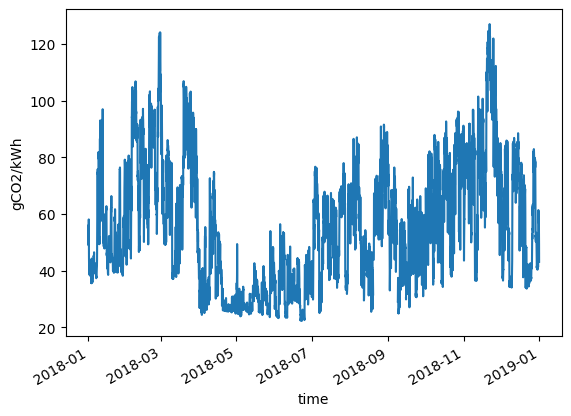

In [4]:
df1['y'].plot(ylabel='gCO2/kWh', xlabel='time', legend=False)
plt.savefig(SAVENAME+".pdf", bbox_inches="tight")

In [7]:
df2 = read_co2_data(FILENAME2,3,5)
df2.head()

,y
ds,
2018-04-01 01:00:00,60.07
2018-04-01 02:00:00,62.15
2018-04-01 03:00:00,63.77
2018-04-01 04:00:00,66.31
2018-04-01 05:00:00,66.32


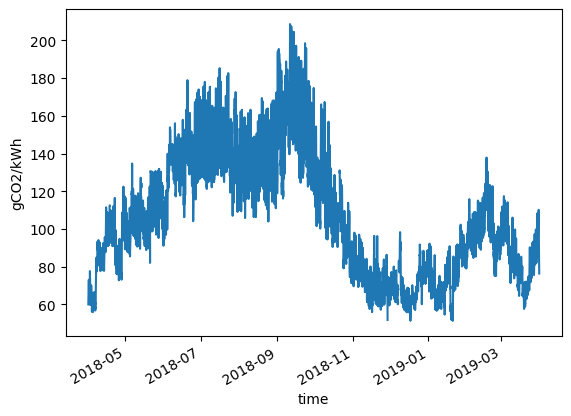

In [8]:
df2['y'].plot(ylabel='gCO2/kWh', xlabel='time', legend=False)
plt.savefig(SAVENAME2+".pdf", bbox_inches="tight")

# Set a Timeframe

In [9]:
# convert strings to datetime
frm = datetime.datetime.fromisoformat(FROM)
to = datetime.datetime.fromisoformat(TO)

df1_hist = get_historical(df1, frm)
df1_hist.tail()

,y
2018-11-16 19:00:00,85.929604
2018-11-16 20:00:00,75.167852
2018-11-16 21:00:00,74.940311
2018-11-16 22:00:00,81.705070
2018-11-16 23:00:00,NaN


In [10]:
df2_hist = get_historical(df2, frm)
df2_hist.tail()

,y
2018-11-16 19:00:00,59.10
2018-11-16 20:00:00,61.12
2018-11-16 21:00:00,60.35
2018-11-16 22:00:00,59.32
2018-11-16 23:00:00,NaN


# Get Test Data

In [11]:
df1_test = get_testdata(df1, frm, to)
df1_test.head()

,y
2018-11-17 00:00:00,65.751408
2018-11-17 01:00:00,63.525797
2018-11-17 02:00:00,62.995845
2018-11-17 03:00:00,61.233649
2018-11-17 04:00:00,61.603979


In [12]:
df2_test = get_testdata(df2, frm, to)
df2_test.head()

,y
2018-11-17 00:00:00,61.02
2018-11-17 01:00:00,61.01
2018-11-17 02:00:00,63.95
2018-11-17 03:00:00,67.38
2018-11-17 04:00:00,70.30


1629.77386476
1643.3899999999999


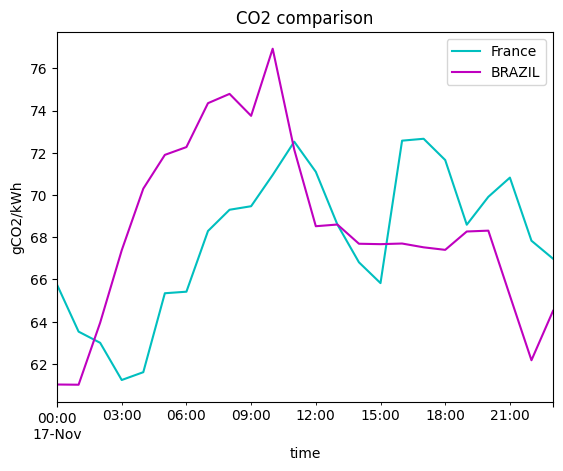

In [13]:
df1_test['y'].plot(label=SAVENAME, legend=True, ylabel='gCO2/kWh', xlabel='time', title='CO2 comparison', color='c')
df2_test['y'].plot(label=SAVENAME2, legend=True,color='m')
plt.savefig(SAVENAME+"_"+SAVENAME2+"_comparison.pdf", bbox_inches="tight")
print (df1_test['y'].sum())
print (df2_test['y'].sum())

# Predict CO2 (Prohpet)

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG Adding TBB (c:\Users\moria\AppData\Local\Programs\Python\Python37\lib\site-packages\prophet\stan_model\cmdstan-2.26.1\stan\lib\stan_math\lib\tbb) to PATH
prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpm3biutqb\hf_j62j_.json
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpm3biutqb\g1lct0vv.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['c:\\Users\\moria\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=14653', 'data', 'file=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\hf_j62j_.json', 'init=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\g1lct0vv.json', 'output', 'file=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\proph

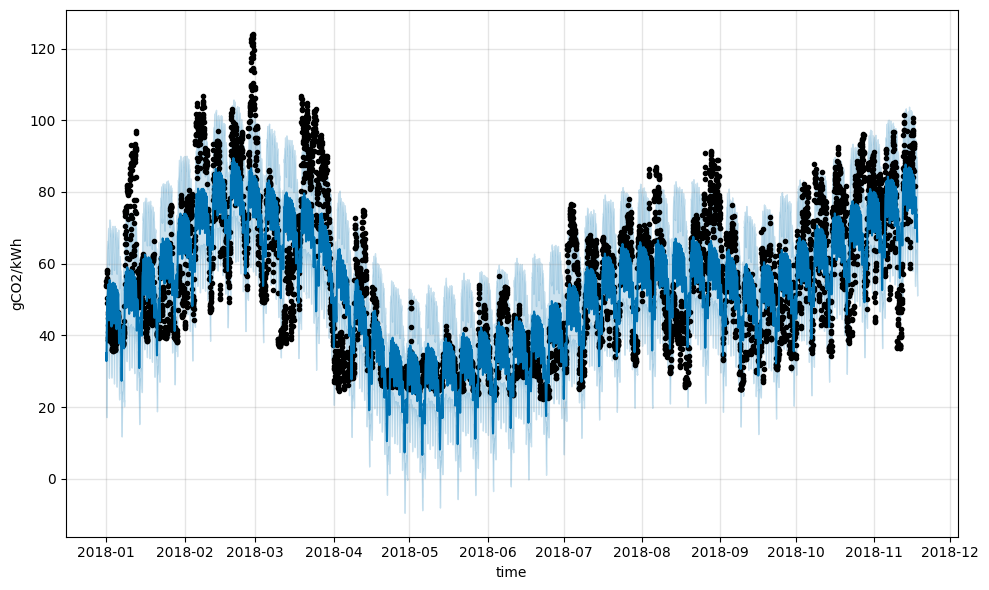

In [14]:
df1_hist['ds'] = df1_hist.index
#df1_hist = df1_hist.interpolate(method='linear')

m = prophet.Prophet()
m.fit(df1_hist)
future = m.make_future_dataframe(periods=STEPS, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast,ylabel='gCO2/kWh',xlabel='time')
# plt.savefig(SAVENAME+"_prophet_chart.pdf", bbox_inches="tight")

cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None
cmdstanpy  DEBUG TBB already found in load path
prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpm3biutqb\f6p4gap5.json
cmdstanpy  DEBUG input tempfile: C:\Users\moria\AppData\Local\Temp\tmpm3biutqb\tckk4lsl.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['c:\\Users\\moria\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=54628', 'data', 'file=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\f6p4gap5.json', 'init=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\tckk4lsl.json', 'output', 'file=C:\\Users\\moria\\AppData\\Local\\Temp\\tmpm3biutqb\\prophet_modelyjs7gjfa\\prophet_model-20230127173156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:56 - cmdstan

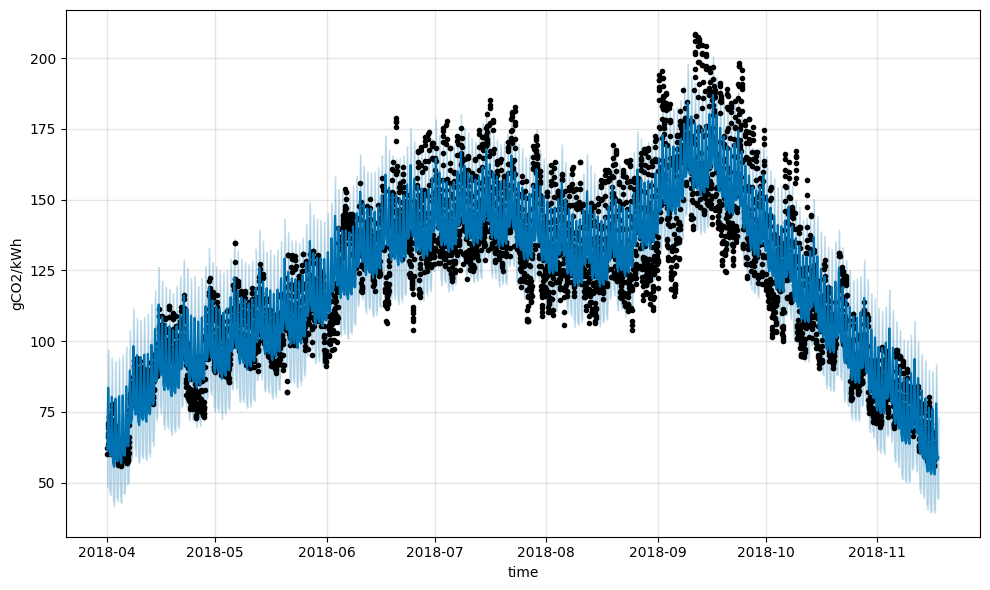

In [15]:
df2_hist['ds'] = df2_hist.index
#df1_hist = df1_hist.interpolate(method='linear')

m2 = prophet.Prophet()
m2.fit(df2_hist)
future2 = m2.make_future_dataframe(periods=STEPS, freq='H')
forecast2 = m2.predict(future2)
fig3 = m2.plot(forecast2,ylabel='gCO2/kWh',xlabel='time')
plt.savefig(SAVENAME2+"_prophet_chart.pdf", bbox_inches="tight")

Trends

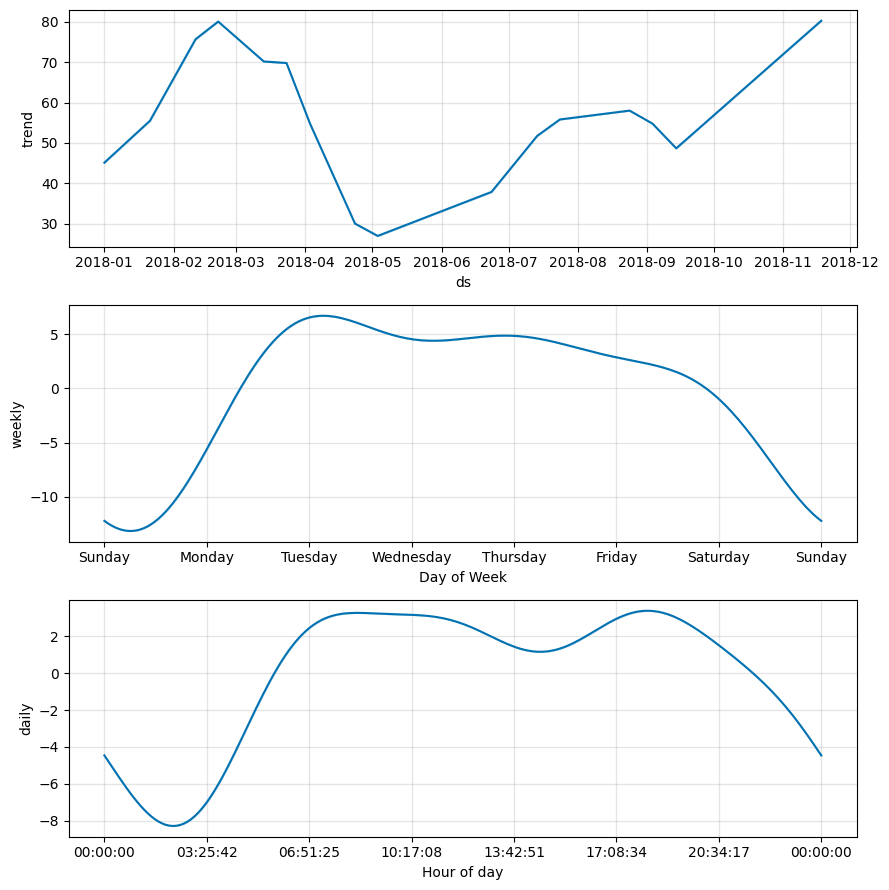

In [16]:
fig2 = m.plot_components(forecast)
plt.savefig(SAVENAME+"_prophet_components.pdf", bbox_inches="tight")

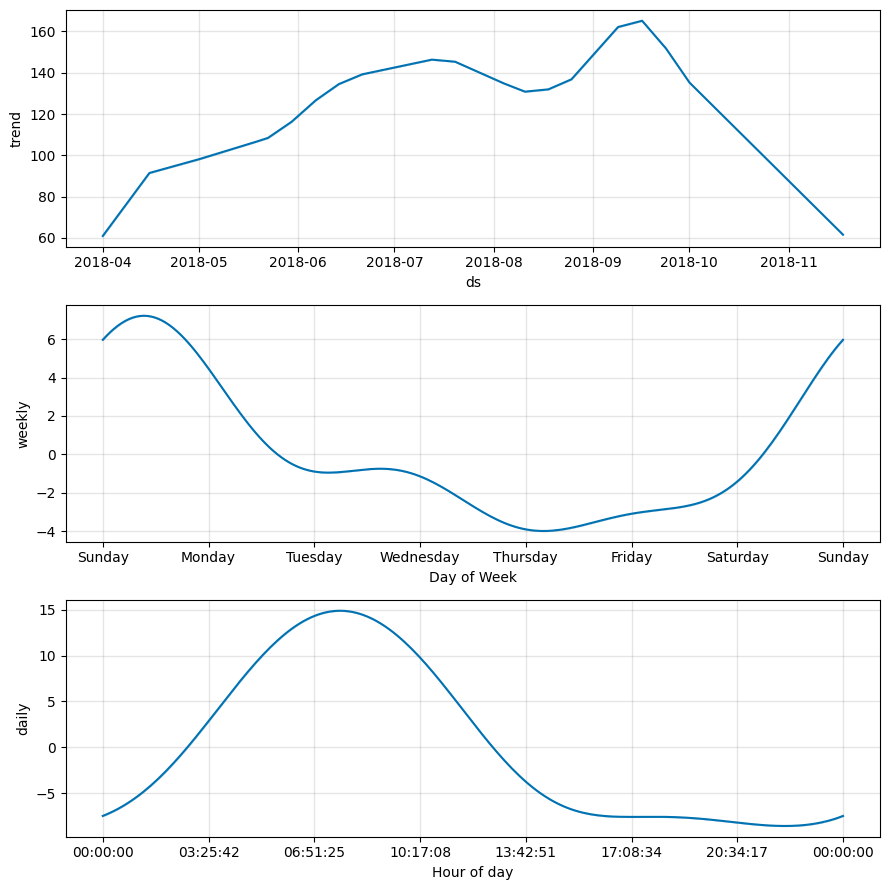

In [17]:
fig4 = m2.plot_components(forecast2)
plt.savefig(SAVENAME2+"_prophet_components.pdf", bbox_inches="tight")

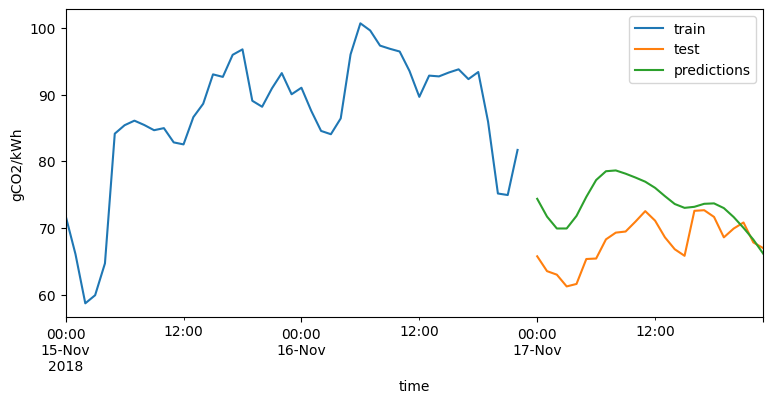

In [18]:
forecast.index = forecast['ds']
fig, ax = plt.subplots(figsize=(9, 4))
df1_hist[-STEPS*2:]['y'].plot(ax=ax, label='train', ylabel='gCO2/kWh')
df1_test['y'].plot(ax=ax, label='test')
forecast['yhat'][-STEPS:].plot(ax=ax, label='predictions', xlabel='time')
plt.savefig(SAVENAME+"_prophet_prediction.pdf", bbox_inches="tight")
ax.legend()

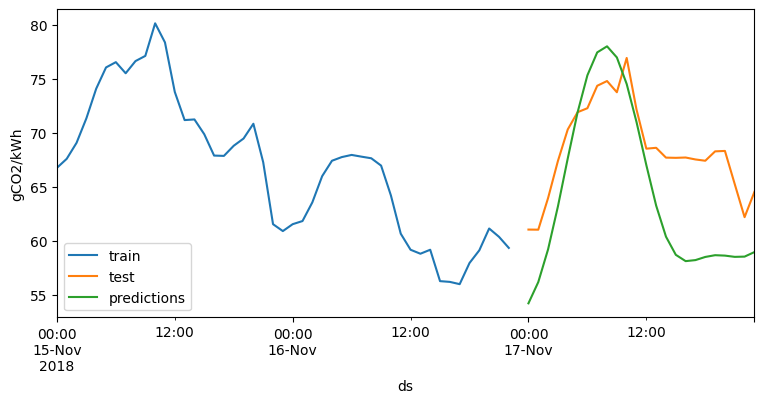

In [19]:
forecast2.index = forecast2['ds']
fig, ax = plt.subplots(figsize=(9, 4))
df2_hist[-STEPS*2:]['y'].plot(ax=ax, label='train')
df2_test['y'].plot(ax=ax, label='test', ylabel='gCO2/kWh', xlabel='time')
forecast2['yhat'][-STEPS:].plot(ax=ax, label='predictions')
plt.savefig(SAVENAME2+"_prophet_prediction.pdf", bbox_inches="tight")
ax.legend()

MAPE

In [20]:
error = mape(df1_test['y'], forecast['yhat'][-STEPS:])
error

0.0875545107440026

In [21]:
error = mape(df2_test['y'], forecast2['yhat'][-STEPS:])
error

0.07794615511904539

LME

In [22]:
observed_min = df1_test[['y']].idxmin()
predicted_min = forecast['yhat'][-STEPS:].idxmin()
print("lme", predicted_min - observed_min)

lme y   0 days 20:00:00
dtype: timedelta64[ns]


In [23]:
observed_min = df2_test[['y']].idxmin()
predicted_min = forecast2['yhat'][-STEPS:].idxmin()
print("lme", predicted_min - observed_min)

lme y   -1 days +23:00:00
dtype: timedelta64[ns]


# Save prediction

In [24]:
if GENERATE:
    np.savetxt("co2_prediction.csv", forecast['yhat'][-STEPS:].to_numpy(), delimiter=",")
    np.savetxt("co2_emission.csv", df1_test['y'].to_numpy(), delimiter=",")
    np.savetxt("co2_prediction2.csv", forecast2['yhat'][-STEPS:].to_numpy(), delimiter=",")
    np.savetxt("co2_emission2.csv", df2_test['y'].to_numpy(), delimiter=",")